# Spezial Chapter -  OEE
## Overall Equipment Effectiveness

![Alt text](OEE%20-%20picture.jpeg)

### Dataprep:

In [7]:
# Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# Load the data
X = pd.read_csv("data_X.csv")
Y = pd.read_csv('data_Y.csv')
S = pd.read_csv('sample_submission.csv')

In [2]:
# Dataprep
X["date_time"] = pd.to_datetime(X["date_time"])
X["date_hour"] = X["date_time"].apply(lambda x: x.strftime("%d-%m-%Y-%H"))
X = X.groupby("date_hour").mean()


In [3]:
#Dataprep
Y["date_shifted"] = pd.to_datetime(Y["date_time"]) - datetime.timedelta(hours=1)
Y["date_shifted"] = pd.to_datetime(Y["date_shifted"])
Y["date_shifted"] = Y["date_shifted"].apply(lambda x: x.strftime("%d-%m-%Y-%H"))
Y.drop(columns=["date_time"], inplace=True)

S["date_shifted"] = pd.to_datetime(S["date_time"]) - datetime.timedelta(hours=1)
S["date_shifted"] = pd.to_datetime(S["date_shifted"])
S["date_shifted"] = S["date_shifted"].apply(lambda x: x.strftime("%d-%m-%Y-%H"))
S.drop(columns=["date_time"], inplace=True)


In [4]:
# Create the Train and Test data
train = pd.merge(X,Y, left_on="date_hour", right_on="date_shifted", how="inner")
test = pd.merge(X,S, left_on="date_hour", right_on="date_shifted", how="inner")

## OEE - Availability

The current dataset's timeline does not accurately reflect the real-world scenario. For demonstration purposes, I have assumed that the machine operates continuously on a 24/7 basis, with shutdowns occurring only for necessary repairs. To estimate availability more accurately, I have further assumed that any sensor failure results in a machine downtime of one hour for repairs.

$$
Availability = \frac{Runtime}{Totaltime}
$$


In [5]:
# Calculation of Availability
def get_anomalies(df, column):
    anomalies = []
    for i in range(len(df)-1):
        if abs(df[column].iloc[i] - df[column].iloc[i+1]) > 2*df[column].std():
            anomalies.append(i)
    return anomalies

error_rate = {i: len(get_anomalies(X, i)) for i in X.columns[1:16]}
#print(error_rate) # error_rate of all rows with 2 Times the standard deviation
sum_errors = sum(error_rate.values()) # Not every row lead to nessessarily a repair
availabilty = round((1- sum_errors/X.shape[0]) *100, 2)

print(f'{availabilty:.2f}% Availability')

73.55% Availability


Text(0.5, 0, 'Error Rate')

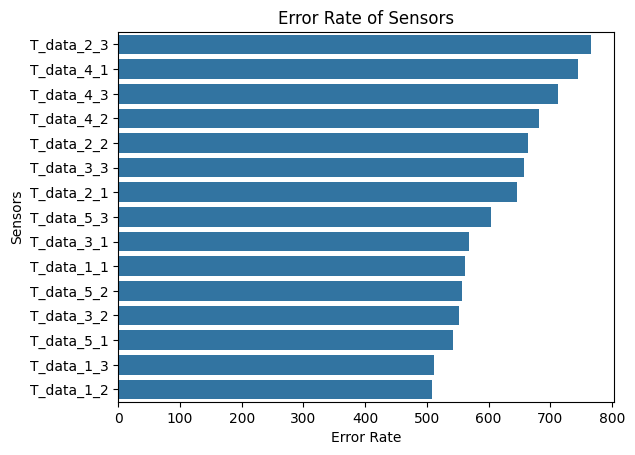

In [6]:
# Plot the Error Rate
df_error = pd.DataFrame(error_rate.items(), columns=["Feature", "Error_Rate"])
df_error.sort_values(by="Error_Rate", ascending=False, inplace=True)
sns.barplot(y="Feature", x="Error_Rate", data=df_error)
plt.title("Error Rate of Sensors")
plt.ylabel("Sensors")
plt.xlabel("Error Rate")

# OEE - Quality

In traditional methodologies, quality is typically calculated by dividing the number of scrap parts by the total number of parts produced. However, in this context, defining a "bad part" is challenging because the quality outcome is represented by a numerical value rather than a binary classification. To address this, we can either assign "weights" to the produced parts based on their quality scores or establish a threshold to classify parts as either good or scrap. The choice between these approaches should be guided by the specific business case, and you, as the customer, will need to determine which metric provides the most meaningful insights.

For the sake of simplicity, I have decided to classify any batch with a quality score below 350 as scrap.

$$
Quality = \frac{Goodparts}{Totalparts (Scrap+Good)}
$$


In [7]:
# df for the anomalies
df = pd.merge(X,Y, left_on="date_hour", right_on="date_shifted", how="inner")

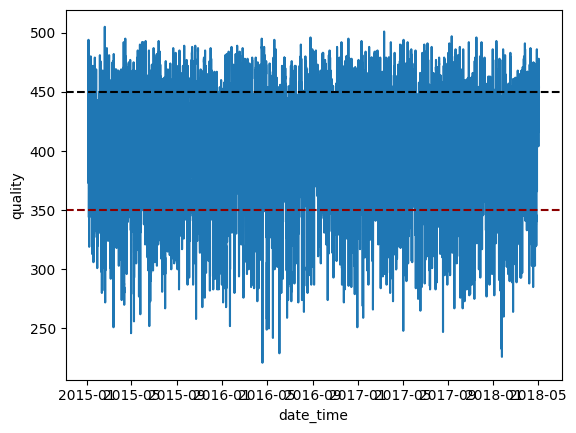

In [8]:
# Determine the boundaries for the quality
sns.lineplot(data=train,x="date_time", y="quality")
plt.axhline(y=450, color='black', linestyle='--')
plt.axhline(y=350, color='darkred', linestyle='--')

In [9]:
# Calculate the quality
df["Scrap"] = (df["quality"] >= 350).astype(int)
good_part = df["Scrap"].value_counts()[1]
scrap_part = df["Scrap"].value_counts()[0]

quality = round(good_part/(good_part+scrap_part)*100, 2)
print(f'{quality:.2f}% quality')

86.02% quality


# OEE - Performance

To assess the performance factor, we need to establish a setpoint for the Cycle Time, which represents the number of parts that can be produced by a machine within a given timeframe. In this example, the exact unit of the provided data is unclear. The column labeled "AH_data" reflects the filling height of Camper One, so we can interpret this measurement as a volume metric.

Analyzing the data reveals that an increase in volume does not negatively impact the quality of the produced batch. For demonstration purposes, I will assume a target Cycle Time of 9 volume units per hour (9 VU/H). 

To calculate the performance, we can determine the average Cycle Time and then divide it by the target value.

$$
Performance = \frac{Current-/AvgCycletime}{Max-/SetCycletime}
$$


In [10]:
# How to interpret the data for the performance
df["AH_data"].describe()

count    29184.000000
mean         7.500540
std          1.146928
min          3.120000
25%          6.730000
50%          7.510000
75%          8.280000
max         11.620000
Name: AH_data, dtype: float64

Text(0.5, 1.0, 'Correlation between AH_data and quality')

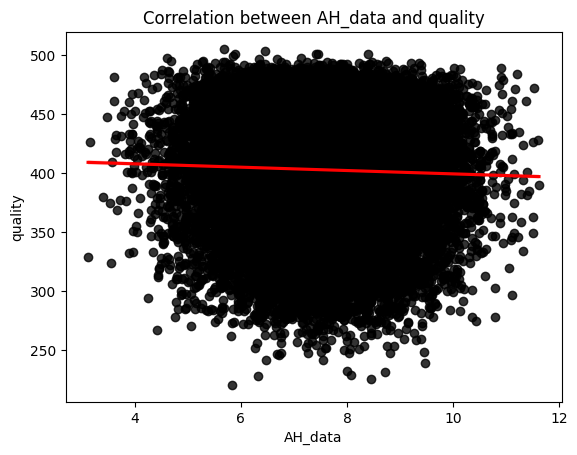

In [11]:
# Check if the AH_data is correlated with the quality
sns.regplot(data=df, x="AH_data", y="quality", scatter_kws={"color": "black"}, line_kws={"color": "red"})
plt.title("Correlation between AH_data and quality")

In [12]:
# Set goal of 9 for the performance

performance_goal = 9 

max_performance = performance_goal*df.shape[0]/df.shape[0]
current_performance = df["AH_data"].mean()

performance = round(current_performance/max_performance*100, 2)
print(f'{performance:.2f}% Performance')

83.34% Performance


# OEE

$$
OEE = Performance * Availability * Quality
$$

In [13]:
# Calculate the OEE 
OEE = round(performance/100 * quality/100 * availabilty/100 * 100, 2)
print(f'{OEE:.2f}% OEE')

52.73% OEE


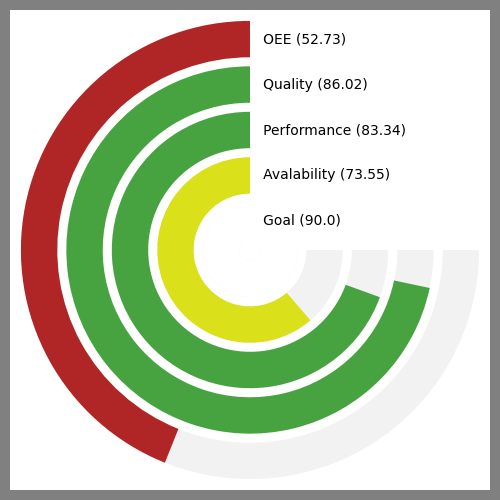

In [14]:
# Visualization of the OEE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

goal = 90

lith_dict = {'LITH': ["Goal", "Avalability", "Performance", "Quality","OEE"],
             'PERCENTAGE': [goal, availabilty, performance, quality,OEE]}

df = pd.DataFrame.from_dict(lith_dict)

max_value_full_ring = max(df['PERCENTAGE'])

#Is used for multible colour variations
#ring_colours = [#'white', '#0040ff',"#022fb8","#002185","black",
#                'white','#8540a3','#405ea3','#40a39e','#40a350',
#                '#003f5c', '#374c80', '#7a5195','#bc5090',
#               '#ef5675','#ff764a','#ffa600']

#Is used for color signal of the ring (example red if value is under 80)
ring_colours = ["#46a340", '#dae019', '#b02525']

ring_labels =  [f'   {x} ({v}) ' for x, v in zip(list(df['LITH']), 
                                                 list(df['PERCENTAGE']))]
data_len = len(df)

fig = plt.figure(figsize=(6,6), facecolor='gray')

rect = [0.1,0.1,0.8,0.8]

# Add axis for chart background
ax_cart = fig.add_axes(rect, facecolor='white')
ax_cart.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax_cart.tick_params(axis='both', left=False, bottom=False, 
                   labelbottom=False, labelleft=False)

# Add axis for radial backgrounds
ax_polar_bg = fig.add_axes(rect, polar=True, frameon=False)
ax_polar_bg.set_theta_zero_location('N')
ax_polar_bg.set_theta_direction(1)

# Loop through each entry in the dataframe and plot a grey
# ring to create the background for each one
for i in range(data_len):
    ax_polar_bg.barh(i, max_value_full_ring*1.5*np.pi/max_value_full_ring, 
                     color='gray', 
                     alpha=0.1)
# Hide all axis items
ax_polar_bg.axis('off')
    
# Add axis for radial chart for each entry in the dataframe
ax_polar = fig.add_axes(rect, polar=True, frameon=False)
ax_polar.set_theta_zero_location('N')
ax_polar.set_theta_direction(1)
ax_polar.set_rgrids([0, 1, 2, 3,4], 
                    labels=ring_labels, 
                    angle=0, 
                    fontsize=10, #fontweight='bold',
                    color='black', verticalalignment='center')

# Loop through each entry in the dataframe and create a coloured 
# ring for each entry
for i in range(data_len):
    if df['PERCENTAGE'][i] == goal:
        ax_polar.barh(i, list(df['PERCENTAGE'])[i]*1.5*np.pi/max_value_full_ring,
                  color="white")
    elif df['PERCENTAGE'][i] > 80:
        ax_polar.barh(i, list(df['PERCENTAGE'])[i]*1.5*np.pi/max_value_full_ring,
                  color=ring_colours[0])
    elif df['PERCENTAGE'][i] < 65:
        ax_polar.barh(i, list(df['PERCENTAGE'])[i]*1.5*np.pi/max_value_full_ring,
                  color=ring_colours[2])
    else:
        ax_polar.barh(i, list(df['PERCENTAGE'])[i]*1.5*np.pi/max_value_full_ring,
                  color=ring_colours[1])
             
# Hide all grid elements for the    
ax_polar.grid(False)
ax_polar.tick_params(axis='both', left=False, bottom=False, 
                   labelbottom=False, labelleft=True)

plt.show()

In [15]:
import plotly.graph_objects as go

fig = go.Figure(go.Indicator(
    domain = {'x': [0, 1], 'y': [0, 1]},
    value = OEE,
    mode = "gauge+number+delta",
    title = {'text': "OEE"},
    delta = {'reference': 65},
    gauge = {'axis': {'range': [None, 120], "tickwidth": 1, "tickcolor": "black"},
            'bar': {'color': "black"},
            'steps' : [
                {'range': [0, 45], 'color': "red"},
                {'range': [45, 70], 'color': "orange"},
                {'range': [60,80], 'color': "yellow"},
                {'range': [80,100], 'color': "green"},
                {'range': [100,120], 'color': "yellow"}],
             'threshold' : {'line': {'color': "black", 'width': 2}, 'thickness': 0.8, 'value': 88}}))

fig.show()

In [16]:
import plotly.graph_objects as go

fig =go.Figure(go.Sunburst(
    labels=["OEE", "Availability", "Performance", "Quality", "Waste","Downtime"],# "Downtime", "Good Parts", "Scrap", "Max. Speed", "Speed_loss"],
    parents=["", "OEE", "OEE", "OEE", "OEE", "Waste"],# "Availability", "Quality", "Quality","Performance", "Performance"],
    values=[ 300, availabilty, performance, quality, 300-quality-availabilty-performance, 100-availabilty ],#, 100-availabilty, availabilty, good_part, scrap_part, max_performance, max_performance-current_performance
    branchvalues="total",
    
    
))
fig.update_layout(margin = dict(t=0, l=0, r=0, b=0))

fig.show()